### TrIP-seq (Polysome profiling) validation
This notebook evaluates to what extent the model can predict the mean ribosome load in endogenous data taken from "Tunable protein synthesis by transcript isoforms in human cells" (Floor & Doudna, 2015). This is an interesting validation, as this data has a similar experimental design (polysome profiling) in the same cell type (HEK293). Moreover, it is at the isoform level, thus presents a lot of 5utr variation. 

In [1]:
from importlib import reload
import re
import random
random.seed(1337)
import os
import pickle

import numpy as np
np.random.seed(1337)
import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import backend as K
from keras.models import load_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import model
import utils

pd.options.mode.chained_assignment = None 

Using TensorFlow backend.


In [2]:
with open("../Data/doudna_polysome_iso.pkl", 'rb') as handle:
    doudna_df = pickle.load(handle)

### Data preparation

Isoforms with the same 5utr are aggregated, as the model naturally can only predict one MRL per utr. Before we aggregate, we subset to isoforms which are detected overall with a tpm > 1.

In [10]:
doudna_rep1 = doudna_df[(doudna_df["count_1"] > 1)]
doudna_rep2 = doudna_df[(doudna_df["count_2"] > 1)]
# replicate 1
fractions_1 = doudna_rep1.select(lambda col: re.match("poly._1|80S_1|cyto_1|utr", col), axis=1).groupby("utr").sum()
count_1 = fractions_1.sum(axis=1)
rl_1 = np.sum(np.array(fractions_1) * np.arange(0,9), axis=1)/np.sum(np.array(fractions_1),axis=1)
aggreg_1 = pd.DataFrame({"utr":fractions_1.index,"count_1":list(count_1),"rl_1":rl_1})
# replicate 2
fractions_2 = doudna_rep2.select(lambda col: re.match("poly._2|80S_2|cyto_2|utr", col), axis=1).groupby("utr").sum()
count_2 = fractions_2.sum(axis=1)
rl_2 = np.sum(np.array(fractions_2) * np.arange(0,9), axis=1)/np.sum(np.array(fractions_2),axis=1)
aggreg_2 = pd.DataFrame({"utr":fractions_2.index,"count_2":list(count_2),"rl_2":rl_2})
# merge
aggreg = aggreg_1.merge(aggreg_2, on="utr")
# mean
aggreg["rl_mean"] = (aggreg["count_1"]*aggreg["rl_1"] + aggreg["count_2"]*aggreg["rl_2"])/(aggreg["count_1"] + aggreg["count_2"])
aggreg["library"] = "egfp_unmod_1"

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  after removing the cwd from sys.path.
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  if __name__ == '__main__':


### Prediction

In [6]:
new_model = load_model("../Models/basic_model_scaled.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

In [11]:
doudna_generator = utils.DataSequence(aggreg, output_col=None, tis_col=None)
predictions_doudna = new_model.predict_generator(doudna_generator)
utils.print_corrs(predictions_doudna.reshape(-1), aggreg["rl_1"])
utils.print_corrs(predictions_doudna.reshape(-1), aggreg["rl_2"])
utils.print_corrs(predictions_doudna.reshape(-1), aggreg["rl_mean"])

Pearson: 0.125, p-val: 0.000, squared: 0.016, Spearman: 0.133, p-val: 0.000
Pearson: 0.142, p-val: 0.000, squared: 0.020, Spearman: 0.144, p-val: 0.000
Pearson: 0.144, p-val: 0.000, squared: 0.021, Spearman: 0.146, p-val: 0.000


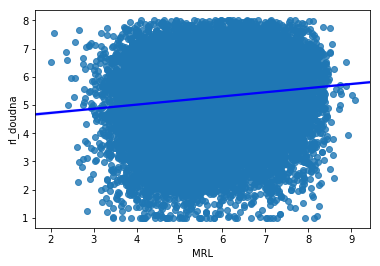

In [33]:
df = pd.DataFrame({"MRL":predictions_doudna.reshape(-1), "rl_doudna":aggreg["rl_1"]})
x = sns.regplot(x='MRL', y="rl_doudna", data=df, line_kws={"color":"b"}).get_figure()

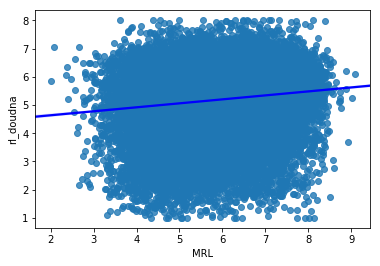

In [34]:
df = pd.DataFrame({"MRL":predictions_doudna.reshape(-1), "rl_doudna":aggreg["rl_2"]})
x = sns.regplot(x='MRL', y="rl_doudna", data=df, line_kws={"color":"b"}).get_figure()

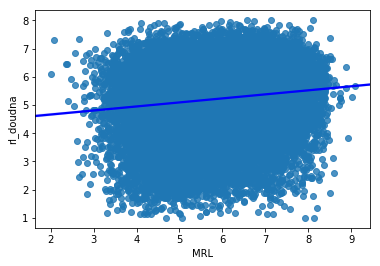

In [35]:
df = pd.DataFrame({"MRL":predictions_doudna.reshape(-1), "rl_doudna":aggreg["rl_mean"]})
x = sns.regplot(x='MRL', y="rl_doudna", data=df, line_kws={"color":"b"}).get_figure()

There is a correlation present, but it is very noisy. In difference to the MPRA data, here the rest of the sequence will impact the MRL (as the paper by Floor & Doudna explains, both the number of splice junctions and the 3utr seem to have an effect, in addition to the 5utr)

### Predicting with the fixed-size model

In [12]:
paper_model = load_model("../Models/retrained_main_MRL_model.hdf5")

In [13]:
aggreg_50 = aggreg.copy()
aggreg_50["utr"] = aggreg_50["utr"].str[-50:]
aggreg_encoded_50 = utils.encode_df(aggreg_50, col="utr", output_col=None, variable_len=True)
predictions_aggreg_50 = paper_model.predict([aggreg_encoded_50["seq"]])
del aggreg_encoded_50

In [14]:
utils.print_corrs(predictions_aggreg_50.reshape(-1), aggreg["rl_1"])
utils.print_corrs(predictions_aggreg_50.reshape(-1), aggreg["rl_2"])
utils.print_corrs(predictions_aggreg_50.reshape(-1), aggreg["rl_mean"])

Pearson: 0.049, p-val: 0.000, squared: 0.002, Spearman: 0.035, p-val: 0.000
Pearson: 0.077, p-val: 0.000, squared: 0.006, Spearman: 0.071, p-val: 0.000
Pearson: 0.067, p-val: 0.000, squared: 0.005, Spearman: 0.055, p-val: 0.000


The fixed size model has far bigger difficulties in predicting the mrl for endogenous data, likely because it can only look at a small part of the 5utr